# Introduction 

In this exercise we build neural network from stratch and apply it to read the hand written digits. Our model is more than 99% accurate in correctly classifying the hand written digits.  

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns; 
%matplotlib inline

from scipy.io import loadmat
import scipy.optimize as opt

# Parameters 

In [2]:
data = loadmat('Data/ex4data1.mat')
X = data['X']
y = data['y']

weights = loadmat('Data/ex4weights.mat')
theta1 = weights['Theta1']
theta2 = weights['Theta2']

nn_params = np.append(theta1.flatten(), theta2.flatten())

(m,n) = X.shape
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10
lmbda = 1

# Visualization 

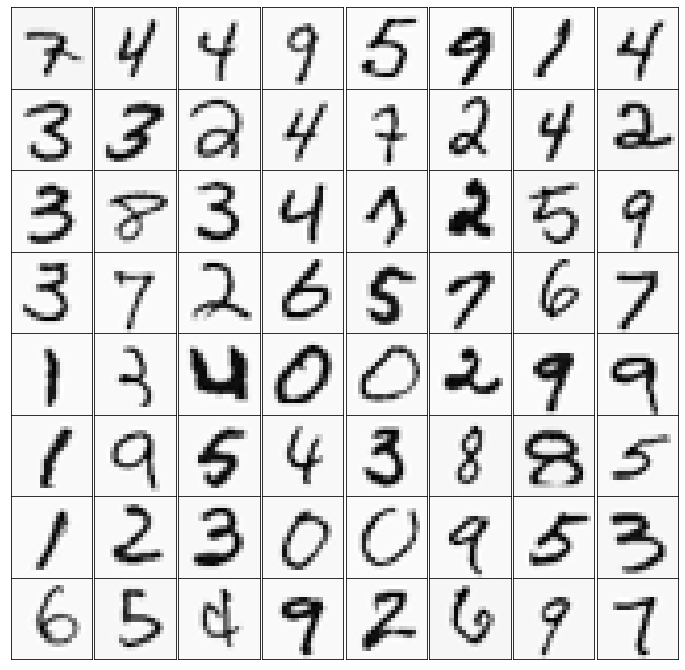

In [3]:
sq_grid = 8
fig, ax = plt.subplots(sq_grid, sq_grid, figsize = (12, 12))
for i in range(sq_grid):
    for j in range(sq_grid):
        rnd_img = np.random.randint(X.shape[0])
        ax[i,j].imshow(data['X'][rnd_img].reshape((20, 20), order = 'F'), cmap = 'Greys')
        ax[i, j].xaxis.set_major_locator(plt.NullLocator())
        ax[i, j].yaxis.set_major_locator(plt.NullLocator())
        fig.subplots_adjust(wspace = 0, hspace = 0)

# Important functions 


Sigmoid function: $$ g(z)=\frac{1}{1 + exp(-z)} $$

Hypothesis: $$ h_{\theta}(x) = g(\theta^{T}x)$$

Sigmoid gradient: $$ g'(z) = g(z) (1 - g(z)) $$

In [4]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def hypothesis(theta, X):
    z = np.dot(X, theta.transpose())
    return sigmoid(z)

def sigmoid_grad(z):
    return np.multiply(sigmoid(z), 1-sigmoid(z))

# Cost function 

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K}\left[ - y_k^{(i)} \log(h_{\theta}(x^{(i)})_k) - (1-y_k^{(i)}) \log(1 - h_{\theta}(x^{(i)})_k)\right] + \frac{\lambda}{2m} \left[\sum_{j = 1}^{HL} \sum_{k = 1}^{IL} \left(\Theta_{j,k}^{(1)} \right)^2  + \sum_{j =1}^{OL} \sum_{k=1}^{HL} \left(\Theta_{j,k}^{(2)} \right)^2 \right] $$

In [5]:
def cost_func_reg(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda):
    
    part_len = hidden_layer_size * (input_layer_size + 1)

    theta1 = np.reshape(nn_params[:part_len], (hidden_layer_size, input_layer_size + 1))
    theta2 = np.reshape(nn_params[part_len:], (num_labels, hidden_layer_size + 1))

    reg_1 = np.sum(np.sum(np.power(theta1[:, 1:], 2), axis = 1))
    reg_2 = np.sum(np.sum(np.power(theta2[:, 1:], 2), axis = 1))
    
    a1 = np.c_[np.ones((X.shape[0], 1)), X]
    a2 = hypothesis(theta1, a1)
    a2 = np.c_[np.ones((a2.shape[0], 1)), a2]
    a3 = hypothesis(theta2, a2)
    
    y_d = pd.get_dummies(y.flatten())
    first_term = np.multiply(y_d, np.log(a3))
    second_term = np.multiply(1 - y_d, np.log(1 - a3))
    
    return - 1/m * np.sum(np.sum(first_term + second_term)) + lmbda / (2 * m) * (reg_1 + reg_2) 

In [6]:
cost_func_reg(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda)

0.38376985909092354

# Random initializtion 

Initialization of theta parameter should be random in order to break the symmetry. There would be no optimization for the symmetric initialization.

In [7]:
def random_initialization(input_layer_size, hidden_layer_size, number_of_output):
    
    theta1 = np.random.rand(hidden_layer_size, input_layer_size + 1)
    theta2 = np.random.rand(number_of_output, hidden_layer_size + 1)
    
    return np.append(theta1.flatten(), theta2.flatten())

nn_initial_params = random_initialization(input_layer_size, hidden_layer_size, num_labels)

# Back propagation 

It includes the following steps: 

(1) First, calculate the hypothesis $h$ by forward propagation 

(2) Calculate the residue of the error of the estimation in the last layer: 
    $$ \delta^{(3)}_k = a^{(3)}_k - y_k $$
    
(3) Calculate the same for the hidden layer using following relation: 
    $$ \delta^{(2)}_k = \left( \left(\Theta^{(2)} \right)^T \delta^{(3)} \right) \cdot g'(z^{(2)})  $$
    
    
(4) Update the gradients: 
    $$ \Delta^{(l)} = \Delta^{(l)} + \delta^{(l + 1)} \left(a^{(l)} \right)^T $$
    
 
(5) Then gradients are given by the following relations: 
    $$ \frac{\partial}{\partial\Theta_{ij}^{(l)}} J(\Theta) = \frac{1}{m} \Delta_{ij}^{(l)} \quad \quad\quad \text{for} \quad j = 0 $$
  
   $$ \frac{\partial}{\partial\Theta_{ij}^{(l)}} J(\Theta) = \frac{1}{m} \Delta_{ij}^{(l)} + \frac{1}{m} \Theta_{ij}^{(l)} \quad \quad \text{for} \quad j \geq 0 $$

In [8]:
def nn_grad(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda):
    
    ones = np.ones(1)
    y_d = pd.get_dummies(y.flatten())
    th_cut = hidden_layer_size * (input_layer_size + 1)
    initial_theta1 = np.reshape(nn_params[:th_cut], (hidden_layer_size, input_layer_size + 1))
    initial_theta2 = np.reshape(nn_params[th_cut:], (num_labels, hidden_layer_size + 1))    
    delta1 = np.zeros(initial_theta1.shape)
    delta2 = np.zeros(initial_theta2.shape)
    
    for i in range(X.shape[0]):
        a1 = np.hstack((ones, X[i]))        
        z2 = np.dot(a1, initial_theta1.transpose())
        a2 = sigmoid(z2)
        a2 = np.hstack((ones, sigmoid(z2)))
        z3 = np.dot(a2, initial_theta2.transpose())
        h = sigmoid(z3)
        d3 = h - y_d.iloc[i]
        sig_grad2 = sigmoid_grad(np.hstack((ones, z2)))
        d2 = np.multiply(np.dot(d3, initial_theta2), sig_grad2)        
        delta1 = delta1 + np.outer(d2[1:], a1)
        delta2 = delta2 + np.outer(d3, a2)

    th_1 = initial_theta1
    th_2 = initial_theta2
    th_1[:, 0] = 0
    th_2[:, 0] = 0
    grad1 = (delta1 + lmbda * th_1)/m 
    grad2 =  (delta2 + lmbda * th_2)/m 
        
    return np.append(grad1.flatten(), grad2.flatten())

In [9]:
nn_backprop_Params = nn_grad(nn_initial_params, input_layer_size, 
                             hidden_layer_size, num_labels, X, y, lmbda)

In [10]:
nn_backprop_Params

array([1.95411983e-05, 2.43864679e-05, 4.01351135e-05, ...,
       9.00160958e-01, 9.00180679e-01, 9.00046270e-01])

# Gradient check 

$$ \frac{\Delta J}{\Delta \theta} = \lim_{\epsilon \to 0} \frac{J(\theta + \epsilon) - J(\theta - \epsilon)}{2\epsilon} $$

In [11]:
def gradient_check(nn_initial_params, nn_backprop_Params, input_layer_size, 
                   hidden_layer_size, num_labels, X, y):
    epsilon = 0.0001
    n_len = len(nn_initial_params) 
    print('Original gradien \t\t\t Computed gradient \t\t\t Differece \n')
    for i in range(10):
        x = int(np.random.rand() * n_len)
        epsvec = np.zeros((n_len, 1))
        epsvec[x] = epsilon
        
        th_plus = nn_initial_params + epsvec.flatten()
        th_minus = nn_initial_params - epsvec.flatten()

        cost_plus = cost_func_reg(th_plus, input_layer_size, hidden_layer_size, 
                                  num_labels, X, y, lmbda = 0)
        cost_minus  = cost_func_reg(th_minus, input_layer_size, hidden_layer_size, 
                                    num_labels, X, y, lmbda = 0)
        mygrad = 1/(2 * epsilon) * (cost_plus - cost_minus)
        
        print(mygrad, '\t\t\t', nn_backprop_Params[x], '\t\t\t', 
              mygrad - nn_backprop_Params[x])

In [12]:
gradient_check(nn_initial_params, nn_backprop_Params, input_layer_size, 
               hidden_layer_size, num_labels, X, y)

Original gradien 			 Computed gradient 			 Differece 

2.7681323899741983e-06 			 9.996284982527039e-05 			 -9.71947174352962e-05
0.0 			 8.898575502004235e-05 			 -8.898575502004235e-05
0.0 			 0.00013796889152300885 			 -0.00013796889152300885
2.1316282072803006e-10 			 0.00019779218838466496 			 -0.00019779197522184423
2.409215937859699e-05 			 0.00012217721021392386 			 -9.808505083532687e-05
1.4210854715202004e-09 			 1.7297157277548323e-05 			 -1.7295736192076802e-05
7.105427357601002e-10 			 0.00014271070208104295 			 -0.0001427099915383072
-6.892264536872972e-08 			 0.00018134406703200056 			 -0.0001814129896773693
-2.7000623958883807e-09 			 0.00017471644249293715 			 -0.00017471914255533304
0.0 			 0.00012542985826711613 			 -0.00012542985826711613


# Optimization 

In [13]:
theta_opt = opt.fmin_cg(f = cost_func_reg, x0 = nn_params, fprime = nn_grad, \
                        args = (input_layer_size, hidden_layer_size, num_labels, X, y, lmbda), \
                        maxiter = 70, epsilon = 0.001, retall = True)

         Current function value: 0.317776
         Iterations: 70
         Function evaluations: 169
         Gradient evaluations: 169


In [14]:
cost_list = []
for i in range(len(theta_opt[1])):
    cost = cost_func_reg(theta_opt[1][i], input_layer_size, hidden_layer_size, 
                         num_labels, X, y, lmbda)
    cost_list.append(cost)

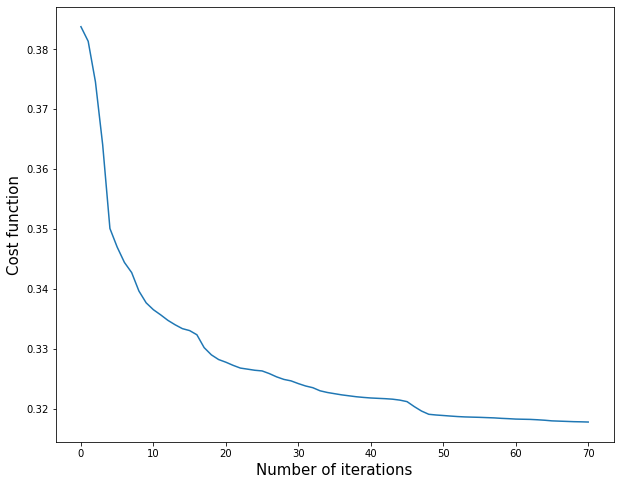

In [15]:
plt.figure(figsize = (10, 8))
plt.plot(cost_list)
plt.ylabel('Cost function', size = 15)
plt.xlabel('Number of iterations', size = 15)
plt.show()

# Prediction 

In [16]:
def predict(theta_opt, X, y):
    
    th_cut = hidden_layer_size * (input_layer_size + 1)
    theta1_opt = np.reshape(theta_opt[0][:th_cut], (hidden_layer_size, input_layer_size + 1))
    theta2_opt = np.reshape(theta_opt[0][th_cut:], (num_labels, hidden_layer_size + 1))
    
    a1 = np.c_[np.ones((X.shape[0], 1)), X]
    a2 = hypothesis(theta1_opt, a1)
    a2 = np.c_[np.ones((a2.shape[0], 1)), a2]
    h = hypothesis(theta2_opt, a2)
    return np.argmax(h, axis = 1) + 1

In [17]:
pred = predict(theta_opt, X, y)
print('Training accuracy: \t', np.mean(y.flatten() == pred) * 100, '%')

Training accuracy: 	 99.14 %
